In [1]:
import random
import os
import pickle
import pandas as pd

from conf_ensemble_library import ConfEnsembleLibrary
from rdkit import Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles, MakeScaffoldGeneric, GetScaffoldForMol
from collections import Counter
from typing import List

import seaborn as sns

In [2]:
random.seed(42)

In [3]:
data_dir_path = 'data/'

In [4]:
all_CEL = ConfEnsembleLibrary()
all_CEL.load()

100%|████████████████████████████████████| 14385/14385 [00:20<00:00, 692.67it/s]


In [5]:
smiles_df = pd.read_csv(os.path.join(data_dir_path, 'smiles_df.csv'))

In [6]:
all_mols = [ce.mol for smiles, ce in all_CEL.get_unique_molecules()]

In [7]:
len(all_mols)

14385

In [8]:
def get_scaffold(mol, generic=False) :
    try :
        core = GetScaffoldForMol(mol)
        if generic :
            core = MakeScaffoldGeneric(mol=core)
        scaffold = Chem.MolToSmiles(core)
        return scaffold
    except Exception as e :
        print(str(e))
        raise Exception('Didnt work')

In [9]:
all_generic_scaffolds = []
correct_smiles = []
for mol in all_mols :
    try :
        scaffold = get_scaffold(mol)
        all_generic_scaffolds.append(scaffold)
        correct_smiles.append(Chem.MolToSmiles(mol))
    except Exception as e :
        print('Didnt work')
        print(str(e))

In [10]:
counter = Counter(all_generic_scaffolds)

In [11]:
print(len(counter))

8775


In [12]:
#http://rdkit.blogspot.com/2020/09/interactively-exploring-scaffoldnetwork.html
#from rdkit.Chem.Scaffolds.rdScaffoldNetwork import CreateScaffoldNetwork, ScaffoldNetworkParams
#snp = ScaffoldNetworkParams()
#sn = CreateScaffoldNetwork(all_mols, snp)

In [24]:
scaffold5to10 = [Chem.MolFromSmiles(scaffold) for scaffold, count in counter.most_common()[5:10]]

In [25]:
random.shuffle(scaffold5to10)

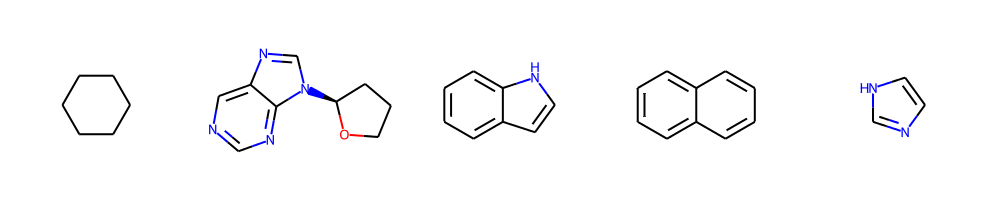

In [26]:
Chem.Draw.MolsToGridImage(scaffold5to10, molsPerRow=5)

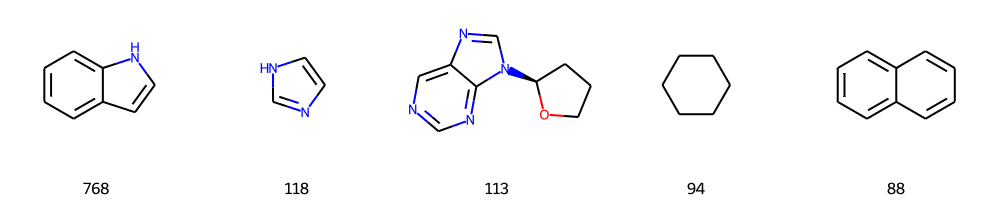

In [19]:
most_counted_scaffold = []
for scaffold, count in counter.most_common() :
    most_counted_scaffold.append(scaffold)
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in counter.most_common()[5:10] if scaffold != ''], 
                          molsPerRow=5,
                         legends=[str(count) for scaffold, count in counter.most_common() if scaffold != ''])

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

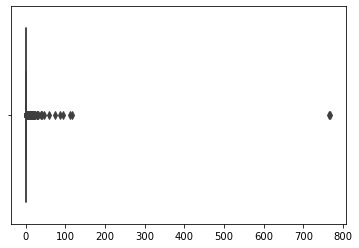

In [16]:
set_sizes = [count for scaffold, count in counter.items()]
sns.boxplot(set_sizes)

In [17]:
frac_train = 0.8
frac_val = 0.1

train_cutoff = int(frac_train * len(correct_smiles))
val_cutoff = int((frac_train + frac_val) * len(correct_smiles))
train_inds = []
val_inds = []
test_inds = []

In [18]:
train_cutoff

11508

In [19]:
val_cutoff

12946

In [20]:
unique_scaffolds = list(counter.keys())

In [21]:
scaffold_splits_dir_name = 'ligand_scaffold_splits'
scaffold_splits_dir_path = os.path.join(data_dir_path, scaffold_splits_dir_name)
if not os.path.exists(scaffold_splits_dir_path) :
    os.mkdir(scaffold_splits_dir_path)

In [22]:
for i in range(5) :
    
    random.shuffle(unique_scaffolds)
    
    train_inds: List[int] = []
    val_inds: List[int] = []
    test_inds: List[int] = []
    
    for scaffold in unique_scaffolds:
        indices = [i for i, s in enumerate(all_generic_scaffolds) if s == scaffold]
        if len(train_inds) + len(indices) > train_cutoff:
            if len(train_inds) + len(val_inds) + len(indices) > val_cutoff:
                test_inds += indices
            else:
                val_inds += indices
        else:
            train_inds += indices
            
    train_smiles = [smiles for i, smiles in enumerate(correct_smiles) if i in train_inds]
    val_smiles = [smiles for i, smiles in enumerate(correct_smiles) if i in val_inds]
    test_smiles = [smiles for i, smiles in enumerate(correct_smiles) if i in test_inds]
    
    with open(os.path.join(scaffold_splits_dir_path, f'train_smiles_scaffold_split_{i}.txt'), 'w') as f :
        for smiles in train_smiles :
            f.write(smiles)
            f.write('\n')
        
    with open(os.path.join(scaffold_splits_dir_path, f'val_smiles_scaffold_split_{i}.txt'), 'w') as f :
        for smiles in val_smiles :
            f.write(smiles)
            f.write('\n')
        
    with open(os.path.join(scaffold_splits_dir_path, f'test_smiles_scaffold_split_{i}.txt'), 'w') as f :
        for smiles in test_smiles :
            f.write(smiles)
            f.write('\n')

In [23]:
len(train_inds)

11508

In [24]:
len(val_inds)

1438

In [25]:
len(test_inds)

1439